<a href="https://www.kaggle.com/code/zlatanshev/titanic-df-shevchenko?scriptVersionId=198654124" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
# Standard python libraries
import time

# Essential DS libraries
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch

import matplotlib.pyplot as plt
import seaborn as sns

import plotly
import plotly.express as px

import category_encoders as ce

from sklearn import preprocessing

import geopy.geocoders
from geopy.geocoders import Nominatim

import warnings
warnings.filterwarnings("ignore")

from sklearn import tree 
from sklearn import ensemble 

from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import RidgeCV

from sklearn.feature_selection import RFE

import optuna

from sklearn.model_selection import cross_val_score

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [7]:
# для корректной обработки признаков объединяем трейн и тест в один датасет
train_data['sample'] = 1 # помечаем где у нас трейн
test_data['sample'] = 0 # помечаем где у нас тест
test_data['Survived'] = 0 # в тесте у нас нет значения Survived, мы его должны предсказать, по этому пока просто заполняем нулями

titan_data = pd.concat([train_data, test_data], ignore_index=True).reset_index(drop=True)

In [8]:
titan_data.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,sample
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


In [9]:
titan_data.Name[:20]

0                               Braund, Mr. Owen Harris
1     Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                Heikkinen, Miss. Laina
3          Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                              Allen, Mr. William Henry
5                                      Moran, Mr. James
6                               McCarthy, Mr. Timothy J
7                        Palsson, Master. Gosta Leonard
8     Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                   Nasser, Mrs. Nicholas (Adele Achem)
10                      Sandstrom, Miss. Marguerite Rut
11                             Bonnell, Miss. Elizabeth
12                       Saundercock, Mr. William Henry
13                          Andersson, Mr. Anders Johan
14                 Vestrom, Miss. Hulda Amanda Adolfina
15                     Hewlett, Mrs. (Mary D Kingcome) 
16                                 Rice, Master. Eugene
17                         Williams, Mr. Charles

In [10]:
titan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     1309 non-null   int64  
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
 12  sample       1309 non-null   int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 133.1+ KB


In [11]:
low_information_cols = [] 

#цикл по всем столбцам
for col in titan_data.columns:
    #наибольшая относительная частота в признаке
    top_freq = titan_data[col].value_counts(normalize=True).max()
    #доля уникальных значений от размера признака
    nunique_ratio = titan_data[col].nunique() / titan_data[col].count()
    # сравниваем наибольшую частоту с порогом
    if top_freq > 0.7:
        low_information_cols.append(col)
        print(f'{col}: {round(top_freq*100, 2)}% одинаковых значений')
    # сравниваем долю уникальных значений с порогом
    if nunique_ratio > 0.7:
        low_information_cols.append(col)
        print(f'{col}: {round(nunique_ratio*100, 2)}% уникальных значений')
# По общим правилам при более 70 % уникальных значений в признаки его следует удалить, но, считаю, что признак важен для дальнейшей модели


PassengerId: 100.0% уникальных значений
Survived: 73.87% одинаковых значений
Name: 99.85% уникальных значений
Parch: 76.55% одинаковых значений
Ticket: 70.97% уникальных значений


In [12]:
titan_data.isnull().sum()

PassengerId       0
Survived          0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
sample            0
dtype: int64

In [13]:
titan_data.Cabin = titan_data.Cabin.fillna(0).apply(lambda x: x if x == 0 else 1)


In [14]:
titan_data.Fare = titan_data.Fare.fillna(titan_data.Fare.median())

In [15]:
titan_data.Embarked = titan_data.Embarked.fillna(titan_data.Embarked.mode()[0])

In [16]:
titan_data.Age = pd.cut(titan_data.Age, [0, 10, 20, 30, 40 , 50, 60, 9999], labels = ['<10', '10-20', '20-30', '30-40', '40-50', '50-60', '+60']).astype('object')

In [17]:
titan_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,sample
0,1,0,3,"Braund, Mr. Owen Harris",male,20-30,1,0,A/5 21171,7.2500,0,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,30-40,1,0,PC 17599,71.2833,1,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,20-30,0,0,STON/O2. 3101282,7.9250,0,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,30-40,1,0,113803,53.1000,1,S,1
4,5,0,3,"Allen, Mr. William Henry",male,30-40,0,0,373450,8.0500,0,S,1


In [18]:
titan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     1309 non-null   int64  
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   object 
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1309 non-null   float64
 10  Cabin        1309 non-null   int64  
 11  Embarked     1309 non-null   object 
 12  sample       1309 non-null   int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 133.1+ KB


In [19]:
titan_data.describe()

,PassengerId,Survived,Pclass,SibSp,Parch,Fare,Cabin,sample
count,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,655.000000,0.261268,2.294882,0.498854,0.385027,33.281086,0.225363,0.680672
std,378.020061,0.439494,0.837836,1.041658,0.865560,51.741500,0.417981,0.466394
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,0.000000,0.000000,7.895800,0.000000,0.000000
50%,655.000000,0.000000,3.000000,0.000000,0.000000,14.454200,0.000000,1.000000
75%,982.000000,1.000000,3.000000,1.000000,0.000000,31.275000,0.000000,1.000000
max,1309.000000,1.000000,3.000000,8.000000,9.000000,512.329200,1.000000,1.000000


In [20]:
titan_data.describe(include='object')

,Name,Sex,Age,Ticket,Embarked
count,1309,1309,1046,1309,1309
unique,1307,2,7,929,3
top,"Connolly, Miss. Kate",male,20-30,CA. 2343,S
freq,2,843,361,11,916


In [21]:
df_age_pred = titan_data.copy()
 # В качестве тестовой выборки возьмем строки с пропусками в признаке Age
test_df = df_age_pred[df_age_pred['Age'].isnull()]
# И удалим эти строчки из таблицы
df_age_pred.dropna(inplace=True)
 # Определим целевой признак и факторы
y_train = df_age_pred['Age']
X_train = df_age_pred.drop(['Name','Age','Ticket', 'PassengerId', 'sample'], axis=1)
X_test = test_df.drop(['Name','Age','Ticket', 'PassengerId', 'sample'], axis=1)

In [22]:
X_train_dummies = pd.get_dummies(X_train)
X_test_dummies = pd.get_dummies(X_test)

In [23]:
model = LogisticRegression(
    multi_class='multinomial', #мультиклассовая классификация
    max_iter=1000, #количество итераций, выделенных на сходимость
    random_state=42 #генерация случайных чисел
)
model.fit(X_train_dummies, y_train)
 
y_pred = model.predict(X_train_dummies)
y_pred.shape

(1046,)

In [24]:
for i, ni in enumerate(test_df.index):
    titan_data.loc[ni, 'Age'] = y_pred[i]

In [25]:
titan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     1309 non-null   int64  
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1309 non-null   object 
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1309 non-null   float64
 10  Cabin        1309 non-null   int64  
 11  Embarked     1309 non-null   object 
 12  sample       1309 non-null   int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 133.1+ KB


<Figure size 640x480 with 0 Axes>

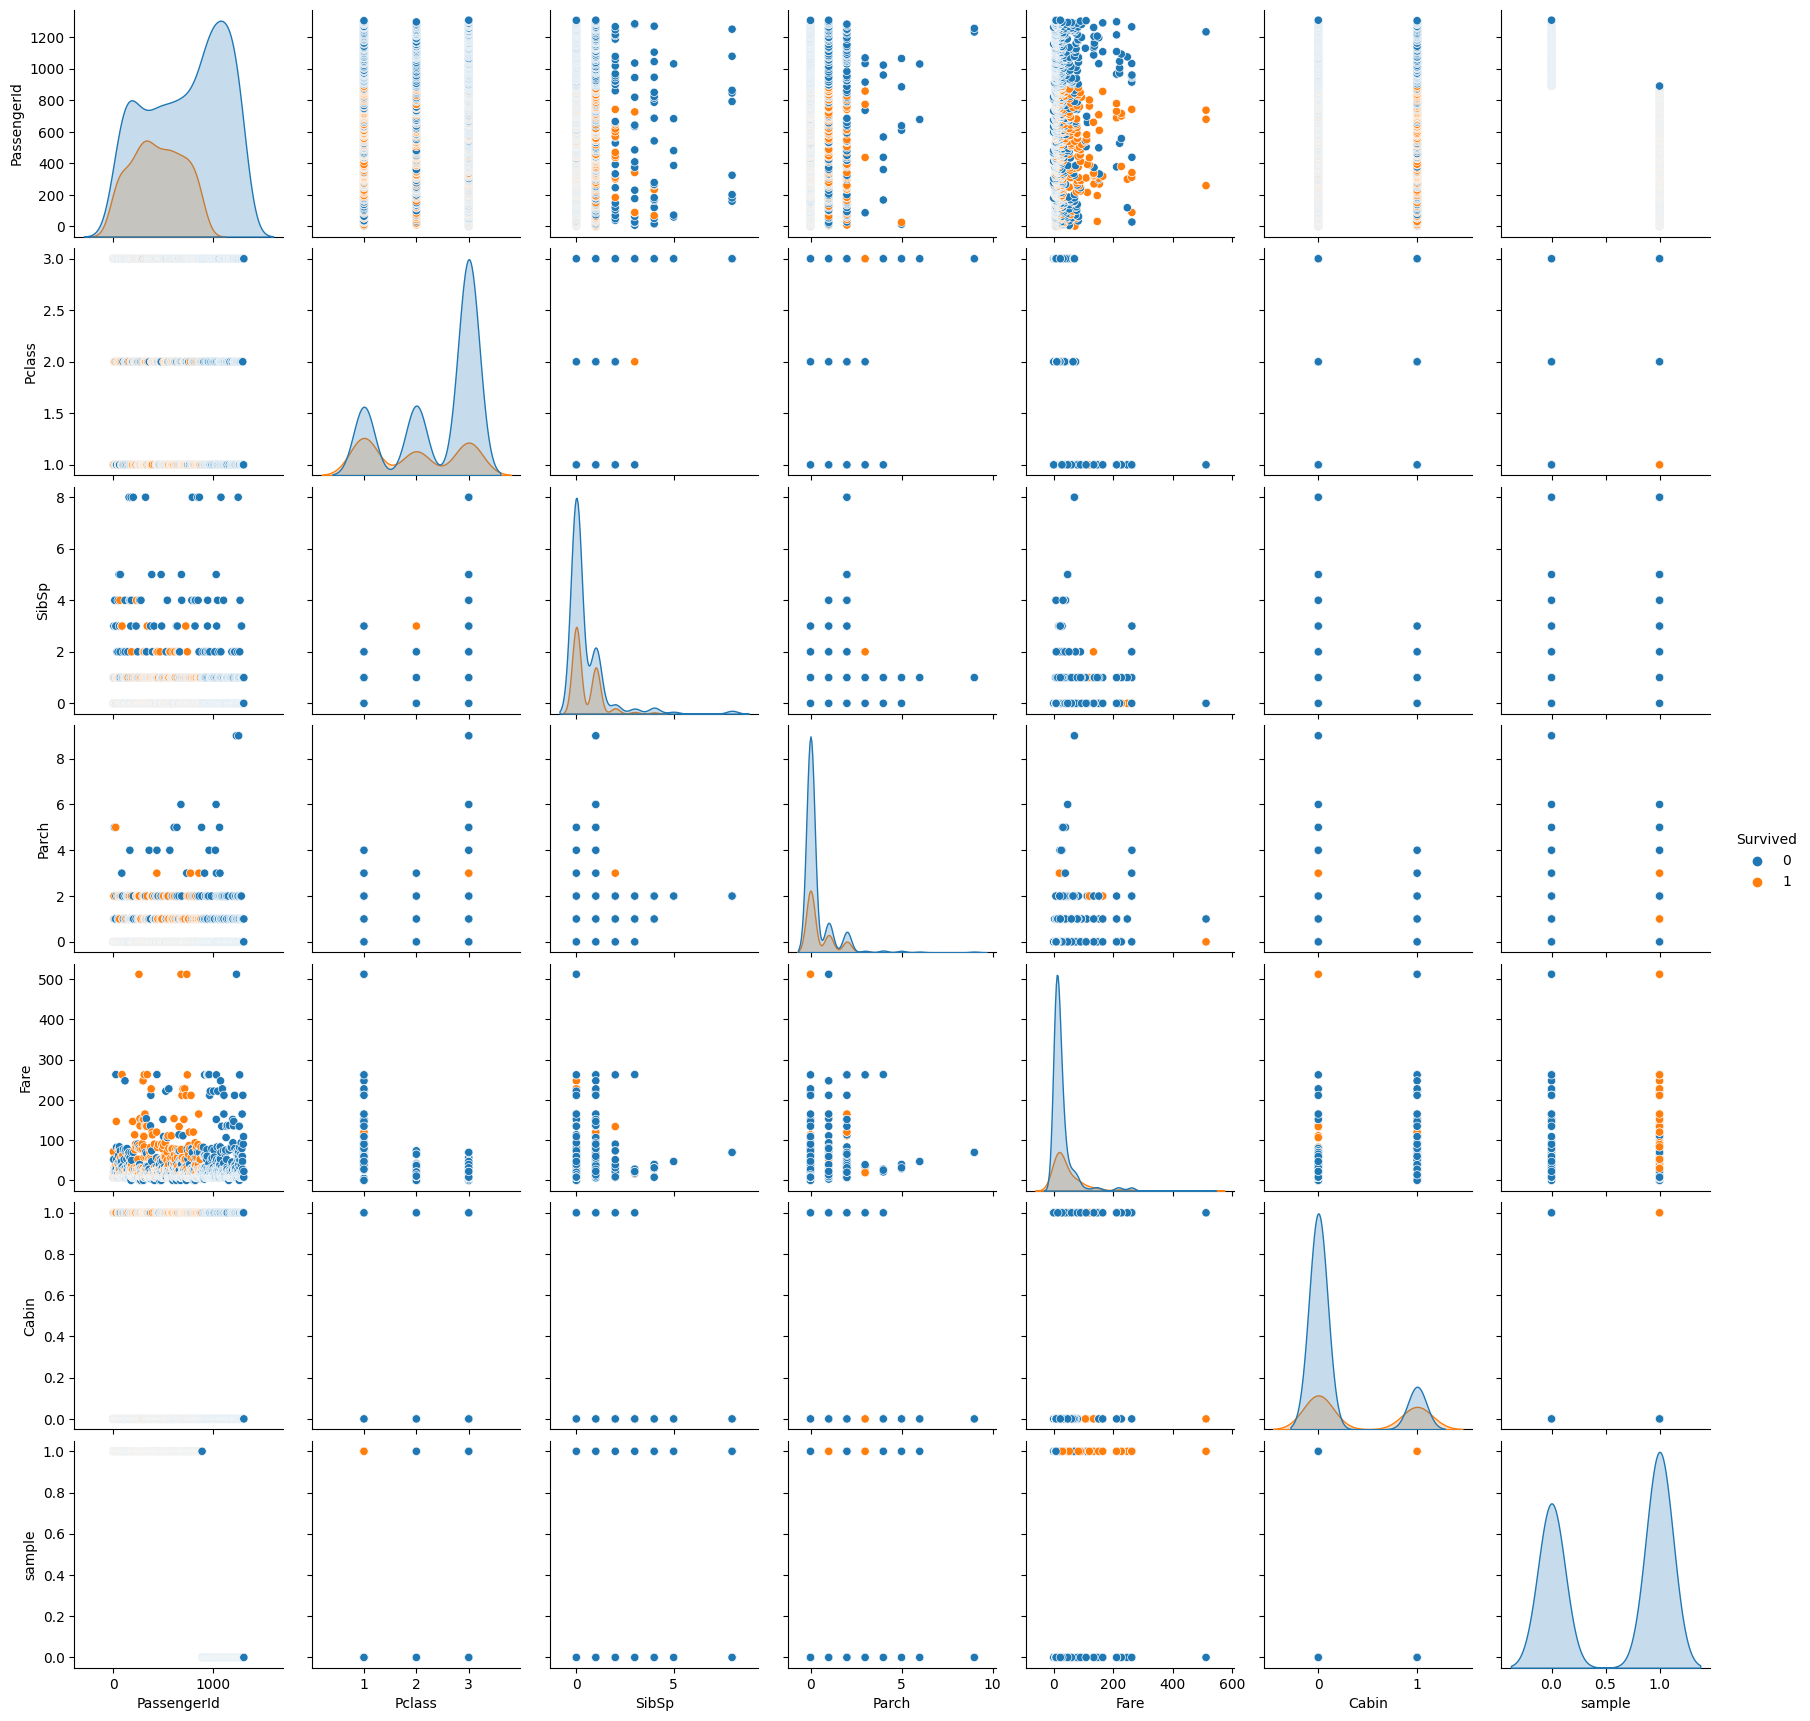

In [26]:
plt.figure()
sns.pairplot(titan_data, hue= 'Survived')
plt.show()

In [27]:
titan_data.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,sample
0,1,0,3,"Braund, Mr. Owen Harris",male,20-30,1,0,A/5 21171,7.2500,0,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,30-40,1,0,PC 17599,71.2833,1,C,1


In [28]:
titan_data.Ticket = titan_data.Ticket.apply(lambda x: 1 if x.isdigit() else 0)

In [29]:
titan_data['Sex'] = titan_data['Sex'].apply(lambda x: 1 if x == 'male' else 0)

In [30]:
# преобразуйте уровни образования
label_encoder = LabelEncoder()
titan_data['Pclass'] = label_encoder.fit_transform(titan_data['Pclass'])
titan_data['Age'] = label_encoder.fit_transform(titan_data['Age'])
titan_data['SibSp'] = label_encoder.fit_transform(titan_data['SibSp'])
titan_data['Parch'] = label_encoder.fit_transform(titan_data['Parch'])

In [31]:
titan_data = titan_data.drop(['Name'], axis=1)

In [32]:
visual_features = list(titan_data.columns)[2:12]
visual_features

['Pclass',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked',
 'sample']

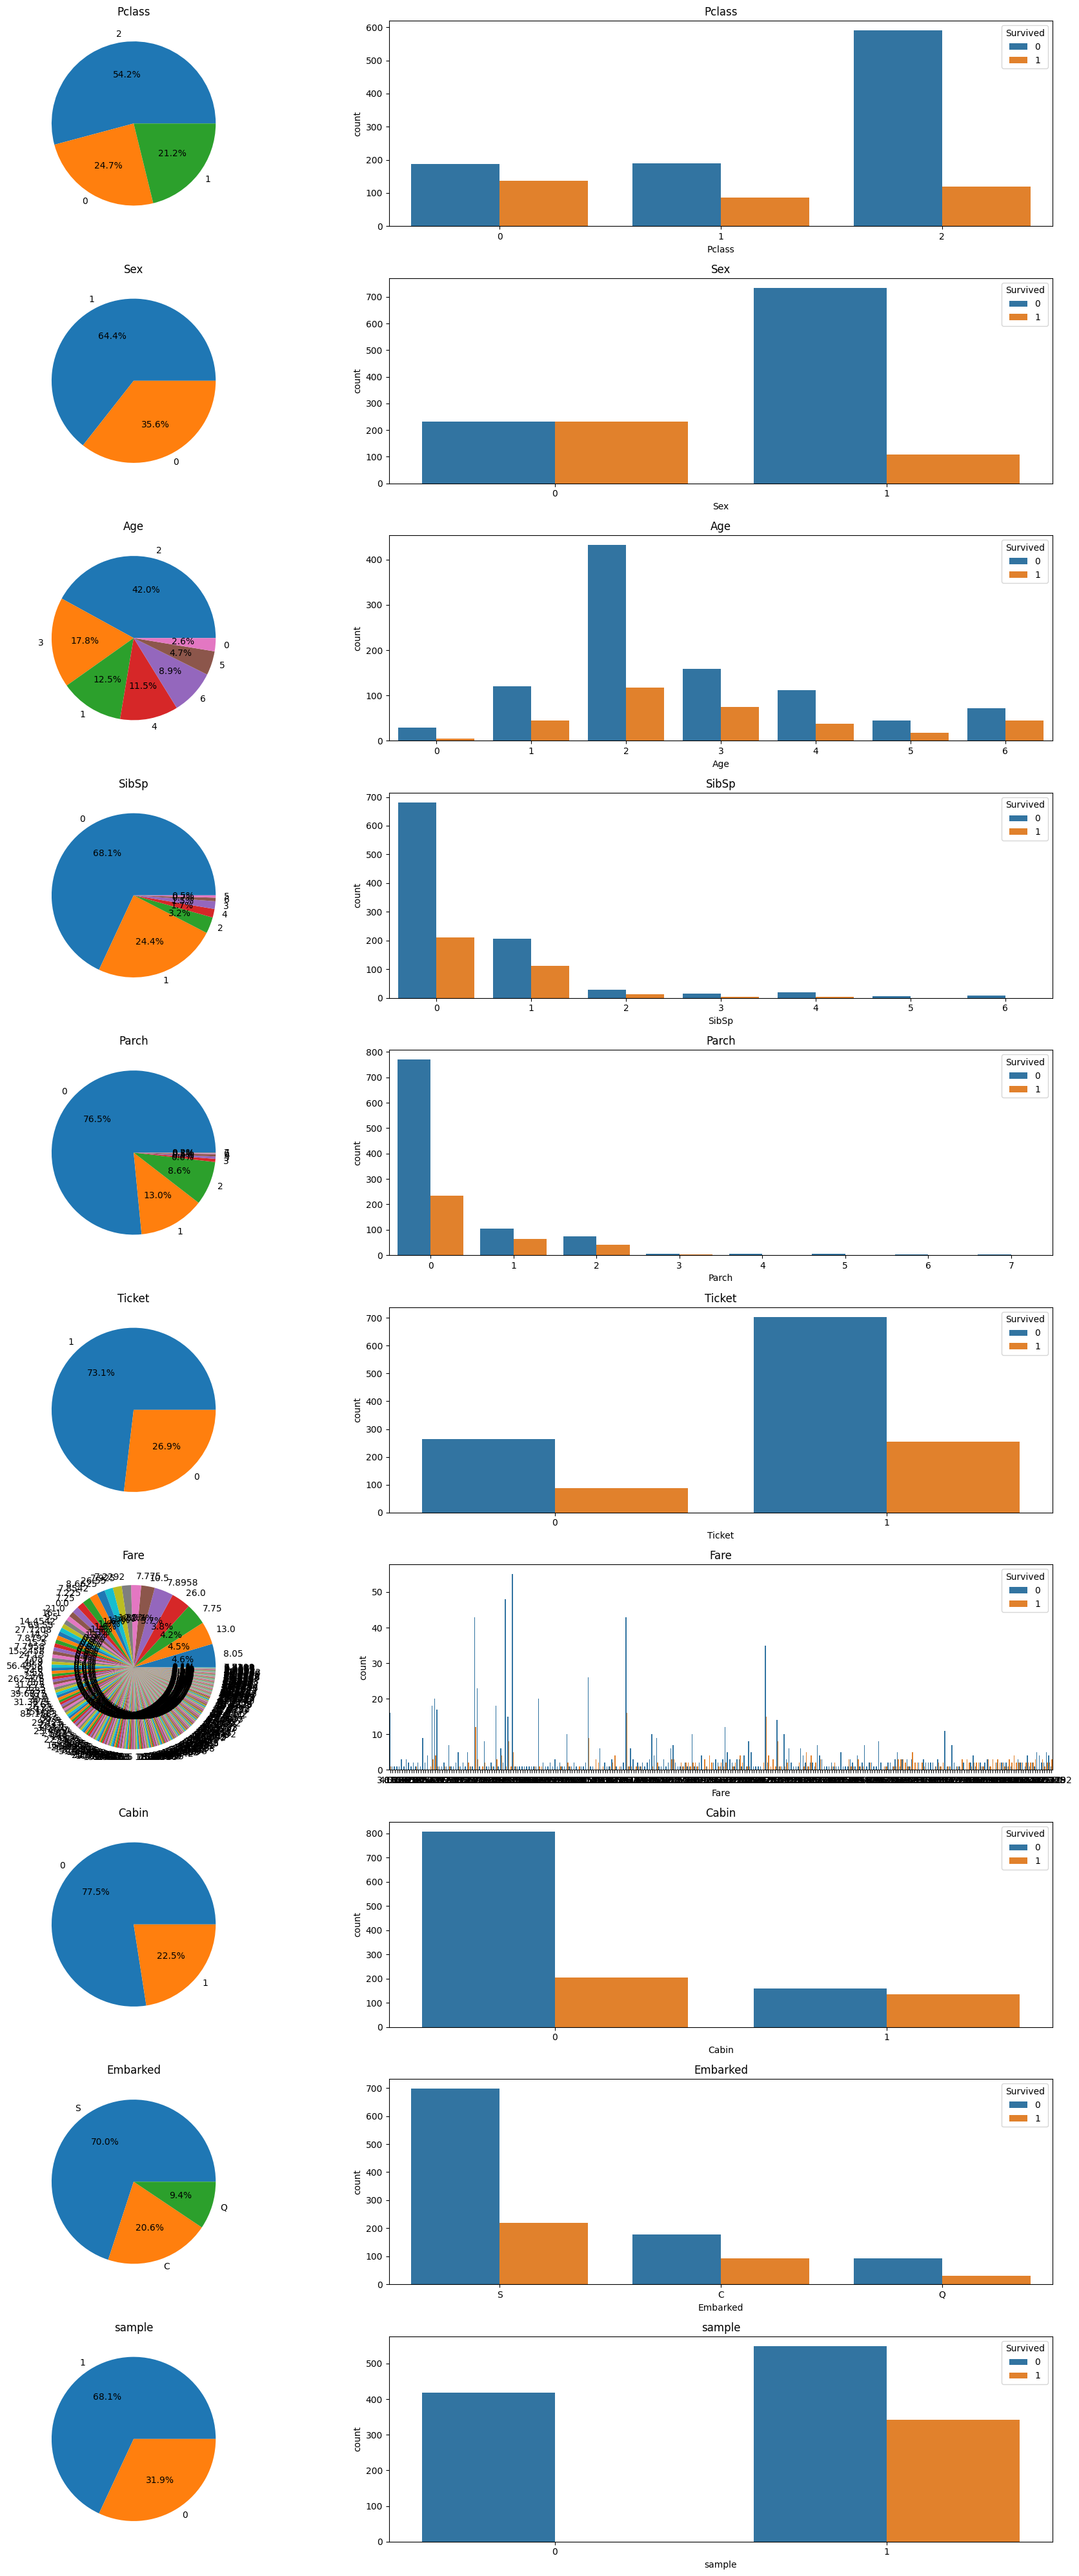

In [33]:
#Создаём цикл для всех признаков из списка 
n = len(visual_features) #число признаков
fig, axes = plt.subplots(n, 2, figsize=(20, 40)) #фигура+n*2 координатных плоскостей
for i, feature in enumerate(visual_features):
    #Строим пирог для процентного соотношения каждой из категорий в данных
    count_data = titan_data[feature].value_counts().rename(feature)
    axes[i][0].pie(count_data, autopct='%.1f%%', labels=count_data.index)
    axes[i][0].set_title(feature)
    sns.countplot(data=titan_data, x=feature, hue='Survived', ax=axes[i][1])
    axes[i][1].set_title(feature)
plt.tight_layout() #выравнивание графиков

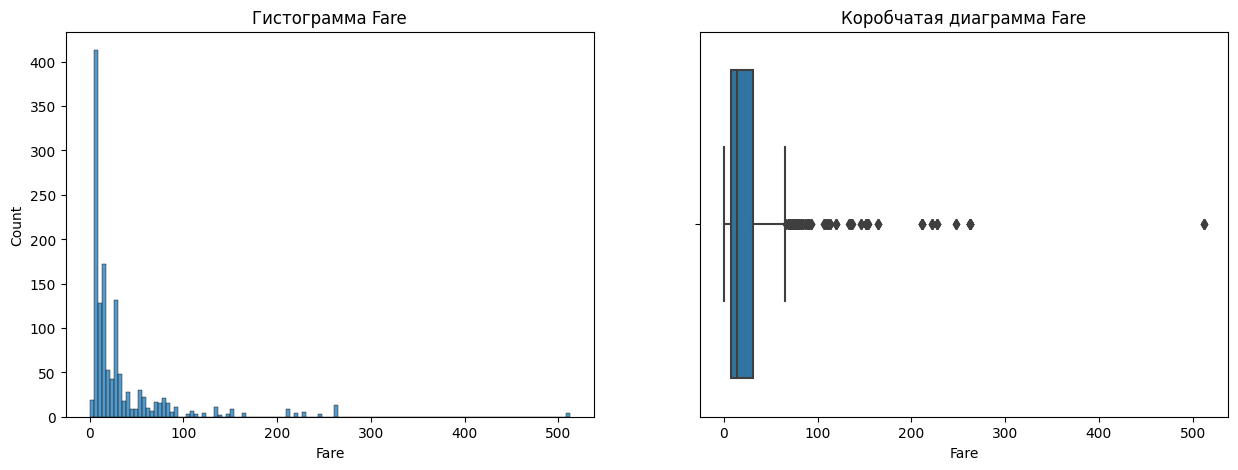

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
hisplot = sns.histplot(titan_data, x='Fare', ax=axes[0]);
hisplot.set_title('Гистограмма Fare');
boxplot = sns.boxplot(titan_data, x='Fare', ax=axes[1]);
boxplot.set_title('Коробчатая диаграмма Fare');

In [35]:
# напишим функцию для отлавливания выбросов по методу Тьюки
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    print(round(lower_bound))
    upper_bound = quartile_3 + (iqr * 1.5)
    print(round(upper_bound))
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned
outliers, cleaned = outliers_iqr(titan_data, 'Fare')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

-27
66
Число выбросов по методу Тьюки: 171
Результирующее число записей: 1138


In [36]:
new_test_data = titan_data.query('sample == 0').drop(['sample'], axis=1)

In [37]:
titan_data = titan_data[(titan_data['Fare'] >= -27) & (titan_data['Fare'] <= 66)]

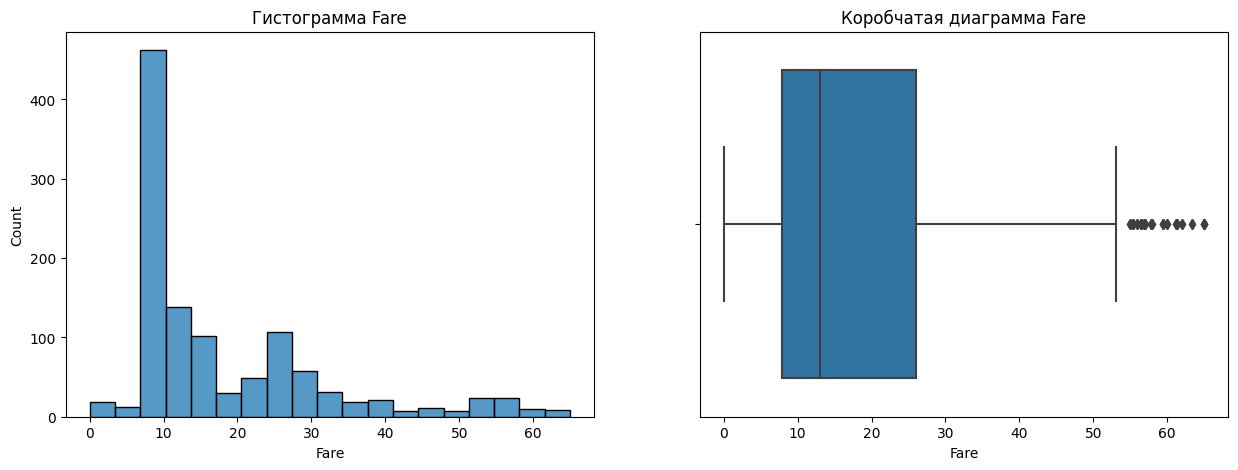

In [38]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
hisplot = sns.histplot(titan_data, x='Fare', ax=axes[0]);
hisplot.set_title('Гистограмма Fare');
boxplot = sns.boxplot(titan_data, x='Fare', ax=axes[1]);
boxplot.set_title('Коробчатая диаграмма Fare');

In [39]:
survived_values = titan_data.Survived.value_counts(normalize=True).__round__(2)
survived_values

Survived
0    0.77
1    0.23
Name: proportion, dtype: float64

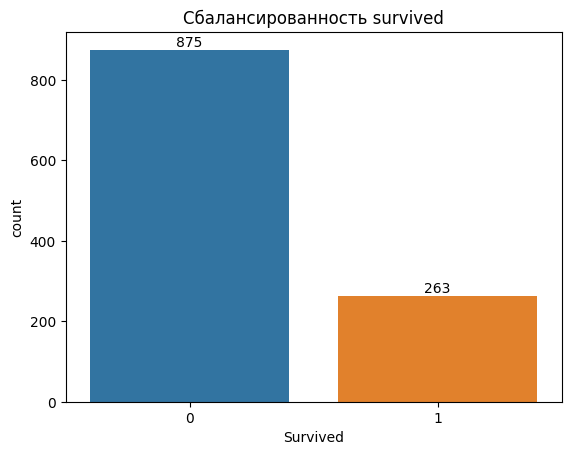

In [40]:
ax = sns.countplot(titan_data, x= 'Survived');
ax.bar_label(ax.containers[0], fontsize=10);
ax.set_title('Сбалансированность survived');

In [41]:
titan_data.head(3)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,sample
0,1,0,2,1,2,1,0,0,7.250,0,S,1
2,3,1,2,0,2,0,0,0,7.925,0,S,1
3,4,1,0,0,3,1,0,1,53.100,1,S,1


In [42]:
df_dummies = pd.get_dummies(titan_data, columns=['Embarked'], dtype=int)

In [43]:
new_test_data = pd.get_dummies(new_test_data, columns=['Embarked'], dtype=int)

In [44]:
df_dummies.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,sample,Embarked_C,Embarked_Q,Embarked_S
0,1,0,2,1,2,1,0,0,7.2500,0,1,0,0,1
2,3,1,2,0,2,0,0,0,7.9250,0,1,0,0,1
3,4,1,0,0,3,1,0,1,53.1000,1,1,0,0,1
4,5,0,2,1,3,0,0,1,8.0500,0,1,0,0,1
5,6,0,2,1,2,0,0,1,8.4583,0,1,0,1,0


<Axes: >

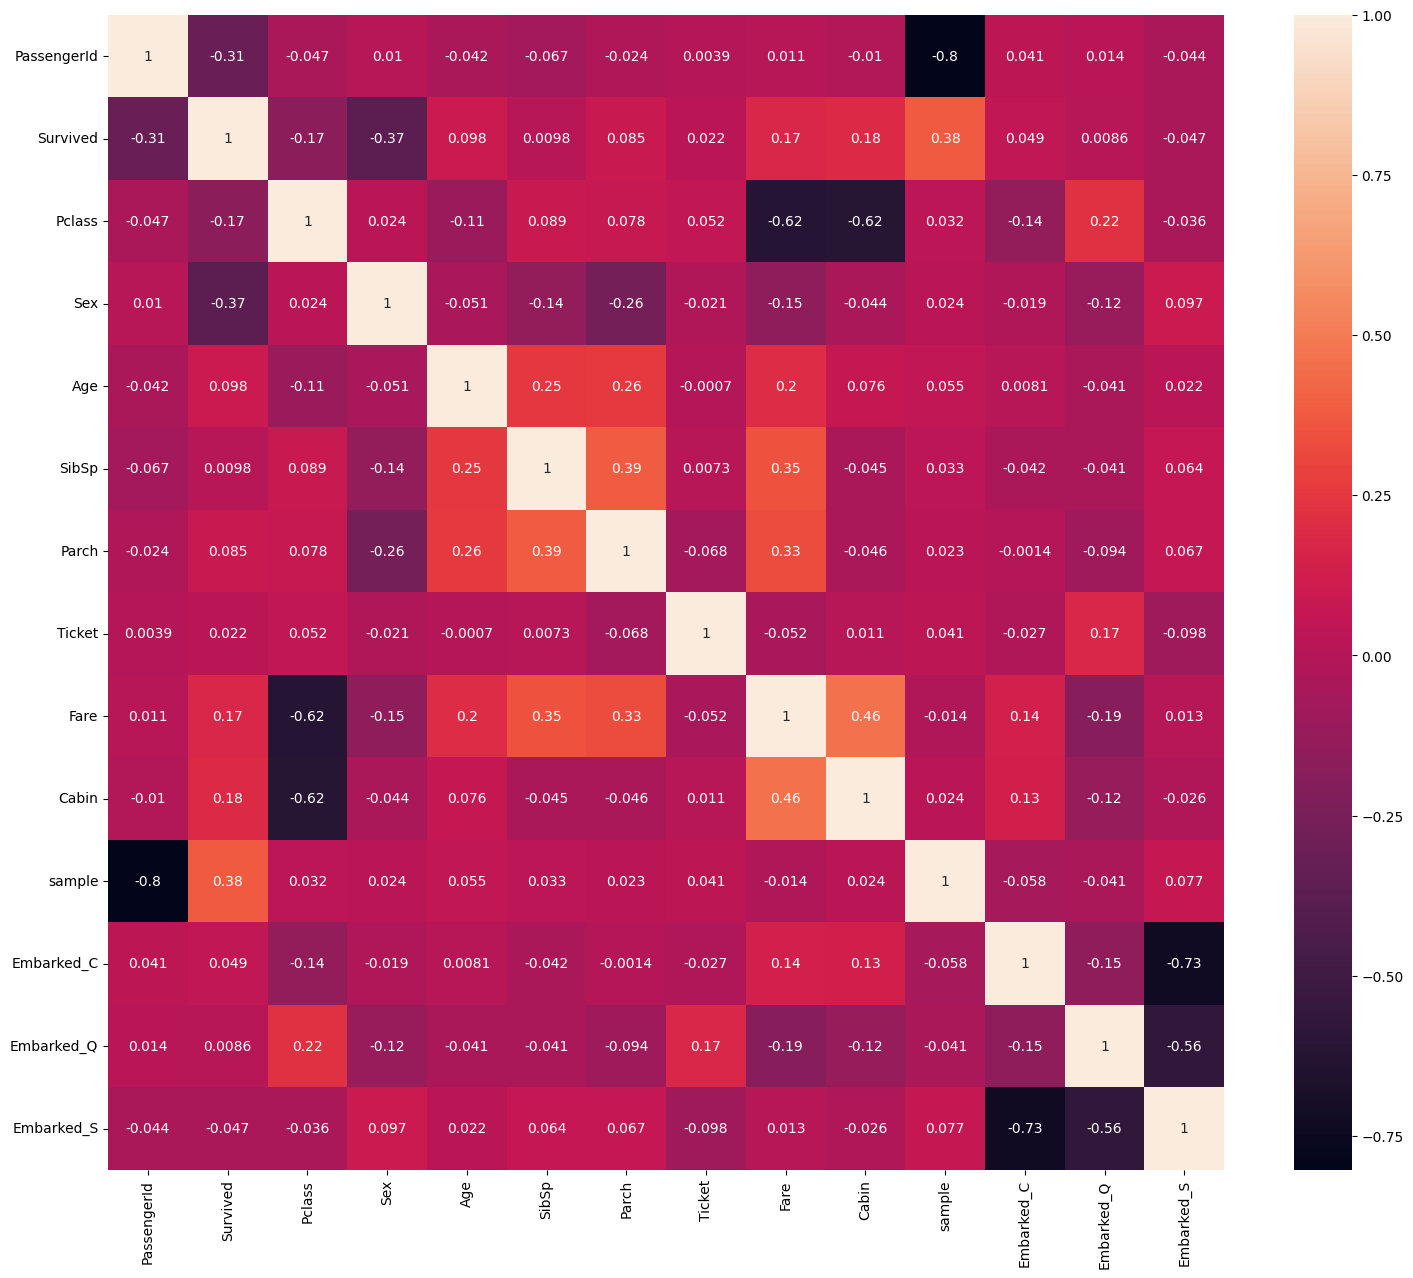

In [45]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(18, 15))
sns.heatmap(df_dummies.corr(), annot=True, ax=ax1)

In [46]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

corr_pairs = get_top_abs_correlations(df_dummies, 30)
corr_pairs

PassengerId  sample        0.803177
Embarked_C   Embarked_S    0.729561
Pclass       Fare          0.621550
             Cabin         0.615766
Embarked_Q   Embarked_S    0.564869
Fare         Cabin         0.460800
SibSp        Parch         0.385349
Survived     sample        0.375212
             Sex           0.370969
SibSp        Fare          0.348604
Parch        Fare          0.325240
PassengerId  Survived      0.314223
Sex          Parch         0.262109
Age          Parch         0.256019
             SibSp         0.250833
Pclass       Embarked_Q    0.221660
Age          Fare          0.203524
Fare         Embarked_Q    0.186095
Survived     Cabin         0.184177
Ticket       Embarked_Q    0.173760
Survived     Fare          0.170660
             Pclass        0.169109
Embarked_C   Embarked_Q    0.152246
Sex          Fare          0.148413
Pclass       Embarked_C    0.140253
Fare         Embarked_C    0.138431
Sex          SibSp         0.137986
Cabin        Embarked_C    0

In [47]:
# Теперь выделим тестовую часть
train_data = df_dummies.query('sample == 1').drop(['sample'], axis=1)


In [48]:
train_data

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked_C,Embarked_Q,Embarked_S
0,1,0,2,1,2,1,0,0,7.2500,0,0,0,1
2,3,1,2,0,2,0,0,0,7.9250,0,0,0,1
3,4,1,0,0,3,1,0,1,53.1000,1,0,0,1
4,5,0,2,1,3,0,0,1,8.0500,0,0,0,1
5,6,0,2,1,2,0,0,1,8.4583,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,1,1,2,0,0,1,13.0000,0,0,0,1
887,888,1,0,0,1,0,0,1,30.0000,1,0,0,1
888,889,0,2,0,2,1,2,0,23.4500,0,0,0,1
889,890,1,0,1,2,0,0,1,30.0000,1,1,0,0


In [49]:
y = train_data.Survived            # наш таргет
X = train_data.drop(['Survived'], axis=1)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = RANDOM_SEED, test_size = 0.2)

In [51]:
X_train

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked_C,Embarked_Q,Embarked_S
38,39,2,0,1,2,0,1,18.0000,0,0,0,1
30,31,0,1,3,0,0,0,27.7208,0,1,0,0
407,408,1,1,6,1,1,1,18.7500,0,0,0,1
615,616,1,0,2,1,2,1,65.0000,0,0,0,1
281,282,2,1,2,0,0,1,7.8542,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
833,834,2,1,2,0,0,1,7.8542,0,0,0,1
112,113,2,1,2,0,0,1,8.0500,0,0,0,1
205,206,2,0,6,0,1,1,10.4625,1,0,0,1
602,603,0,1,2,0,0,1,42.4000,0,0,0,1


In [52]:
new_test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((418, 13), (775, 13), (775, 12), (620, 12), (155, 12))

In [53]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [54]:
new_test_data = new_test_data.drop('Survived', axis=1)

In [55]:
test_scaler = preprocessing.MinMaxScaler()
test_scaler.fit(new_test_data)
test_data_scaled = test_scaler.transform(new_test_data)

In [56]:
test_data_scaled

array([[0.        , 1.        , 1.        , ..., 0.        , 1.        ,
        0.        ],
       [0.00239808, 1.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.00479616, 0.5       , 1.        , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.99520384, 1.        , 1.        , ..., 0.        , 0.        ,
        1.        ],
       [0.99760192, 1.        , 1.        , ..., 0.        , 0.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 0.        ,
        0.        ]])

In [57]:
# обучите логистическую регрессию и рассчитайте метрики качества
linear_model = LogisticRegression(solver='sag',random_state=42, max_iter=1000)
linear_model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='sag')

In [58]:
#Делаем предсказание для тестовой выборки
y_train_pred = linear_model.predict(X_train_scaled)
y_test_pred = linear_model.predict(X_test_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84       410
           1       0.69      0.65      0.67       210

    accuracy                           0.78       620
   macro avg       0.76      0.75      0.75       620
weighted avg       0.78      0.78      0.78       620

              precision    recall  f1-score   support

           0       0.83      0.84      0.83       102
           1       0.69      0.66      0.67        53

    accuracy                           0.78       155
   macro avg       0.76      0.75      0.75       155
weighted avg       0.78      0.78      0.78       155



In [59]:
# подберите оптимальные параметры с помощью gridsearch
param_grid = {'min_samples_split': [2, 3, 5, 7, 10],
              'min_samples_leaf': [2, 3, 5, 7, 10],
              'max_depth':[2,3,5,7],
              'criterion':['gini', 'entropy']
              }
            
grid_search_tree = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42), 
    param_grid=param_grid,
    scoring='f1', 
    cv=2, 
    n_jobs = -1
)  
%time grid_search_tree.fit(X_train_scaled, y_train) 
y_train_pred = grid_search_tree.predict(X_train_scaled)
print(metrics.classification_report(y_train, y_train_pred))
y_test_pred = grid_search_tree.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_test_pred))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_tree.best_params_))

CPU times: user 326 ms, sys: 111 ms, total: 437 ms
Wall time: 3.23 s
              precision    recall  f1-score   support

           0       0.83      0.96      0.89       410
           1       0.90      0.62      0.73       210

    accuracy                           0.85       620
   macro avg       0.86      0.79      0.81       620
weighted avg       0.85      0.85      0.84       620

              precision    recall  f1-score   support

           0       0.77      0.89      0.83       102
           1       0.70      0.49      0.58        53

    accuracy                           0.75       155
   macro avg       0.74      0.69      0.70       155
weighted avg       0.75      0.75      0.74       155

Наилучшие значения гиперпараметров: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2}


In [60]:
# обучим на наших данных случайный лес
#Создаём объект класса случайный лес
rf_df_bank = ensemble.RandomForestClassifier(
    n_estimators=100, #число деревьев
    criterion='gini', #критерий эффективности
    max_depth=7, #максимальная глубина дерева
    min_samples_leaf=5, #число признаков из метода случайных подространств
    random_state=42 #генератор случайных чисел
)
#Обучаем модель 
rf_df_bank.fit(X_train_scaled, y_train)

#Делаем предсказание класса
y_train_pred = rf_df_bank.predict(X_train_scaled)
print(metrics.classification_report(y_train, y_train_pred))
y_test_pred = rf_df_bank.predict(X_test_scaled)
#Выводим отчёт о метриках
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.85      0.96      0.91       410
           1       0.91      0.68      0.78       210

    accuracy                           0.87       620
   macro avg       0.88      0.82      0.84       620
weighted avg       0.87      0.87      0.86       620

              precision    recall  f1-score   support

           0       0.80      0.94      0.86       102
           1       0.83      0.55      0.66        53

    accuracy                           0.81       155
   macro avg       0.81      0.74      0.76       155
weighted avg       0.81      0.81      0.79       155



In [61]:
# Используем для классификации градиентный бустинг и сравним качество со случайным лесом
# Создаем модель градиентного бустинга
gb = GradientBoostingClassifier(
    loss='log_loss', #функция потерь
    learning_rate=0.05, #темп обучения
    n_estimators=300, #число деревьев
    max_depth=5,
    min_samples_leaf=5,#максимальная глубина дерева
    random_state=42 #генератор случайных чисел
)
# Обучаем модель
gb.fit(X_train_scaled, y_train)
# Формируем предсказание для тестовой выборки
y_pred_gb = gb.predict(X_test_scaled)
# Посмотрим на основные метрики классификации
print(classification_report(y_test, y_pred_gb))

              precision    recall  f1-score   support

           0       0.82      0.87      0.84       102
           1       0.72      0.62      0.67        53

    accuracy                           0.79       155
   macro avg       0.77      0.75      0.76       155
weighted avg       0.78      0.79      0.78       155



In [62]:
# Объединим уже известные алгоритмы с помощью стекинга 
# Создаем список кортежей вида: (наименование модели, модель)
estimators = [
    ('gb', GradientBoostingClassifier(
    loss='log_loss', #функция потерь
    learning_rate=0.05, #темп обучения
    n_estimators=300, #число деревьев
    max_depth=5,
    min_samples_leaf=5,#максимальная глубина дерева
    random_state=42 #генератор случайных чисел
    )),
    ('lr', LogisticRegression(
    solver='sag',
    random_state=42, 
    max_iter=1000
    )),
    ('dt', tree.DecisionTreeClassifier(
    criterion='entropy',
    max_depth= 7,
    min_samples_leaf= 2, 
    min_samples_split= 10,
    random_state=42
    ))
]

# Создаем объект класса стекинг
reg = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression()
)
# Обучаем модель
reg.fit(X_train_scaled, y_train)
# Формируем предсказание для тестовой выборки
y_pred_stack = reg.predict(X_test_scaled)
# Оцениваем качество по метрике
print(metrics.classification_report(y_test, y_pred_stack))

              precision    recall  f1-score   support

           0       0.83      0.88      0.86       102
           1       0.74      0.66      0.70        53

    accuracy                           0.81       155
   macro avg       0.79      0.77      0.78       155
weighted avg       0.80      0.81      0.80       155



In [63]:
X_train_scaled = pd.DataFrame(data=X_train_scaled, columns=X_train.columns)
estimator = GradientBoostingClassifier()
selector = RFE(estimator, n_features_to_select=4, step=1)
selector = selector.fit(X_train_scaled, y_train)
 
selector.get_feature_names_out()

array(['PassengerId', 'Pclass', 'Sex', 'Fare'], dtype=object)

In [64]:
estimator = gb
selector = RFE(estimator, n_features_to_select=4, step=1)
selector = selector.fit(X_train_scaled, y_train)
 
selector.get_feature_names_out()

array(['PassengerId', 'Pclass', 'Sex', 'Fare'], dtype=object)

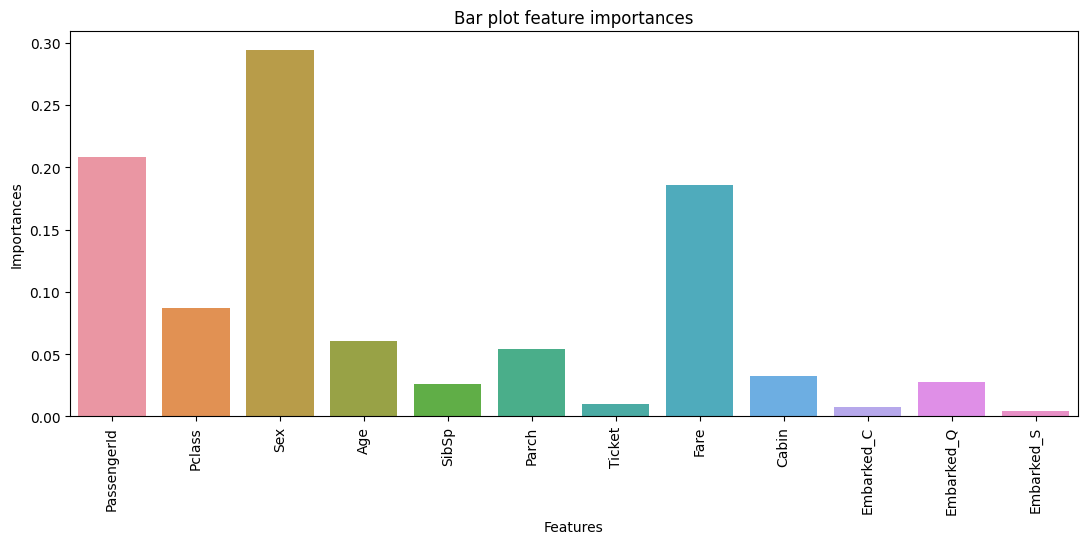

In [65]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
fig, ax = plt.subplots(figsize=(13, 5)) #фигура + координатная плоскость
feature = X_train.columns #признаки
feature_importances = gb.feature_importances_ #важность признаков
#Строим столбчатую диаграмму
sns.barplot(x=feature, y=feature_importances, ax=ax);
#Добавляем подпись графику, осям абсцисс и ординат
ax.set_title('Bar plot feature importances')
ax.set_xlabel('Features')
ax.set_ylabel('Importances')
plt.xticks(rotation = 90);

In [66]:
# реализуем оптимизацию гиперпараметров с помощью Optuna
def optuna_rf(trial):
# задаем пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 70, 200, 1)
    max_depth = trial.suggest_int('max_depth', 5, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10, 1)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 6, 1)
    feat = ['sqrt', 'log2']
    max_features = trial.suggest_categorical('max_features', feat)
    crit = ['gini', 'entropy']
    criterion = trial.suggest_categorical('criterion', crit)

  # создаем модель
    model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                        max_depth=max_depth,
                                        min_samples_leaf=min_samples_leaf,
                                        min_samples_split=min_samples_split,
                                        max_features=max_features,
                                        criterion=criterion,
                                        random_state=42)
  # обучаем модель
    model.fit(X_train_scaled, y_train)
    score_rf = metrics.f1_score(y_train, model.predict(X_train_scaled))
  
  # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    score_rf = cross_val_score(model, X, y, cv=5, scoring="f1", n_jobs=-1).mean()
  

    return score_rf

In [67]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study_rf = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study_rf.optimize(optuna_rf, n_trials=20)

[I 2024-09-28 13:13:00,356] A new study created in memory with name: RandomForestClassifier
[I 2024-09-28 13:13:02,271] Trial 0 finished with value: 0.6377215223026288 and parameters: {'n_estimators': 197, 'max_depth': 6, 'min_samples_leaf': 9, 'min_samples_split': 2, 'max_features': 'sqrt', 'criterion': 'entropy'}. Best is trial 0 with value: 0.6377215223026288.
[I 2024-09-28 13:13:03,343] Trial 1 finished with value: 0.6350064375998576 and parameters: {'n_estimators': 115, 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 5, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 0 with value: 0.6377215223026288.
[I 2024-09-28 13:13:05,141] Trial 2 finished with value: 0.6708856869161781 and parameters: {'n_estimators': 183, 'max_depth': 14, 'min_samples_leaf': 4, 'min_samples_split': 3, 'max_features': 'log2', 'criterion': 'entropy'}. Best is trial 2 with value: 0.6708856869161781.
[I 2024-09-28 13:13:06,373] Trial 3 finished with value: 0.641879149891832 and paramete

CPU times: user 9.93 s, sys: 129 ms, total: 10.1 s
Wall time: 31.8 s


In [68]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study_rf.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study_rf.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 199, 'max_depth': 27, 'min_samples_leaf': 1, 'min_samples_split': 5, 'max_features': 'sqrt', 'criterion': 'gini'}
f1_score на обучающем наборе: 0.69


In [69]:
# рассчитаем точность для тестовой выборки
model_rf = ensemble.RandomForestClassifier(**study_rf.best_params,random_state=42, )
model_rf.fit(X_train_scaled, y_train)
y_train_pred = model_rf.predict(X_train_scaled)
print(metrics.classification_report(y_train, y_train_pred))
y_test_pred = model_rf.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       410
           1       0.95      0.90      0.93       210

    accuracy                           0.95       620
   macro avg       0.95      0.94      0.95       620
weighted avg       0.95      0.95      0.95       620

              precision    recall  f1-score   support

           0       0.84      0.89      0.87       102
           1       0.77      0.68      0.72        53

    accuracy                           0.82       155
   macro avg       0.80      0.79      0.79       155
weighted avg       0.82      0.82      0.82       155



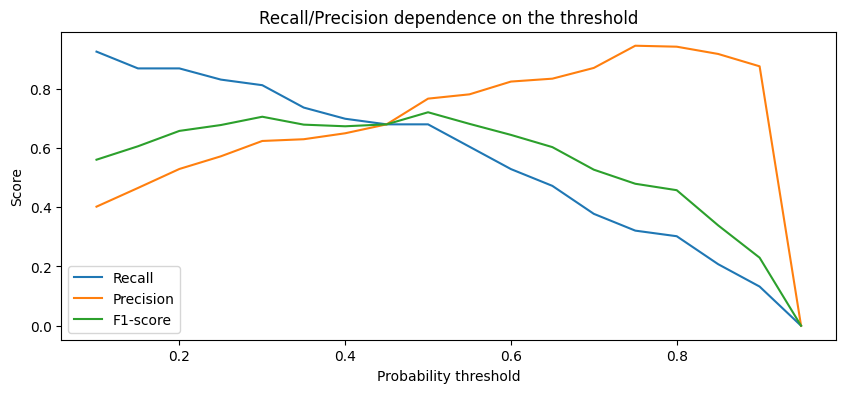

In [70]:
#Нас интересует только вероятность класса (второй столбец)
y_test_proba_pred_rf = model_rf.predict_proba(X_test_scaled)[:, 1]
#Для удобства завернем numpy-массив в pandas Series
y_test_proba_pred_rf = pd.Series(y_test_proba_pred_rf)
#Создадим списки, в которых будем хранить значения метрик 
recall_scores = []
precision_scores = []
f1_scores = []
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)
#В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    #В противном случае - к классу 0
    y_test_pred = y_test_proba_pred_rf.apply(lambda x: 1 if x>threshold else 0)
    #Считаем метрики и добавляем их в списки
    recall_scores.append(metrics.recall_score(y_test, y_test_pred))
    precision_scores.append(metrics.precision_score(y_test, y_test_pred))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))

#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')
#Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')

#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')
#Даем графику название и подписи осям
ax.set_title('Recall/Precision dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.legend();

In [71]:

#Задаем оптимальный порог вероятностей
threshold_opt = 0.47
y_test_pred_opt_rf = y_test_proba_pred_rf.apply(lambda x: 1 if x > threshold_opt else 0)
#Считаем метрики

print(metrics.classification_report(y_test, y_test_pred_opt_rf))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85       102
           1       0.72      0.68      0.70        53

    accuracy                           0.80       155
   macro avg       0.78      0.77      0.77       155
weighted avg       0.80      0.80      0.80       155



In [72]:
def optuna_lr(trial):
  # задаем пространства поиска гиперпараметров
    pen = ['l2', None]
    sol = ['lbfgs', 'saga', 'sag']
    penalty = trial.suggest_categorical('penalty', pen)
    solver = trial.suggest_categorical('solver', sol)
    max_iter = trial.suggest_int('max_iter', 100, 10000, 100)
    C = trial.suggest_uniform('C', 0.01, 1)

  # создаем модель
    model_logreg = LogisticRegression(penalty=penalty,
                                solver=solver,
                                max_iter=max_iter,
                                C=C,
                                random_state=42)
  # обучаем модель
    model_logreg.fit(X_train, y_train)
    score_logreg = metrics.f1_score(y_train, model_logreg.predict(X_train))
  
    return score_logreg

In [73]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study_logreg = optuna.create_study(study_name="LogisticRegression", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study_logreg.optimize(optuna_lr, n_trials=20)

[I 2024-09-28 13:13:33,394] A new study created in memory with name: LogisticRegression
[I 2024-09-28 13:13:33,497] Trial 0 finished with value: 0.6715686274509803 and parameters: {'penalty': None, 'solver': 'lbfgs', 'max_iter': 400, 'C': 0.14561249035969787}. Best is trial 0 with value: 0.6715686274509803.
[I 2024-09-28 13:13:33,587] Trial 1 finished with value: 0.6464646464646465 and parameters: {'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 5500, 'C': 0.28474677923511804}. Best is trial 0 with value: 0.6715686274509803.
[I 2024-09-28 13:13:33,750] Trial 2 finished with value: 0.6617283950617283 and parameters: {'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 2300, 'C': 0.5731806908444613}. Best is trial 0 with value: 0.6715686274509803.
[I 2024-09-28 13:13:34,921] Trial 3 finished with value: 0.43729903536977494 and parameters: {'penalty': None, 'solver': 'saga', 'max_iter': 9800, 'C': 0.652404026596693}. Best is trial 0 with value: 0.6715686274509803.
[I 2024-09-28 13:13:35,852] 

CPU times: user 7.6 s, sys: 29.6 ms, total: 7.63 s
Wall time: 7.63 s


In [74]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study_logreg.best_params))
print("F1 на обучающем наборе: {:.2f}".format(study_logreg.best_value))

Наилучшие значения гиперпараметров {'penalty': None, 'solver': 'lbfgs', 'max_iter': 400, 'C': 0.14561249035969787}
F1 на обучающем наборе: 0.67


In [75]:
# рассчитаем точность для тестовой выборки
model_logreg = LogisticRegression(**study_logreg.best_params,random_state=42, )
model_logreg.fit(X_train_scaled, y_train)
y_train_pred = model_logreg.predict(X_train_scaled)
print(metrics.classification_report(y_train, y_train_pred))
y_test_pred = model_logreg.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84       410
           1       0.69      0.65      0.67       210

    accuracy                           0.78       620
   macro avg       0.76      0.75      0.76       620
weighted avg       0.78      0.78      0.78       620

              precision    recall  f1-score   support

           0       0.83      0.85      0.84       102
           1       0.70      0.66      0.68        53

    accuracy                           0.79       155
   macro avg       0.76      0.76      0.76       155
weighted avg       0.78      0.79      0.79       155



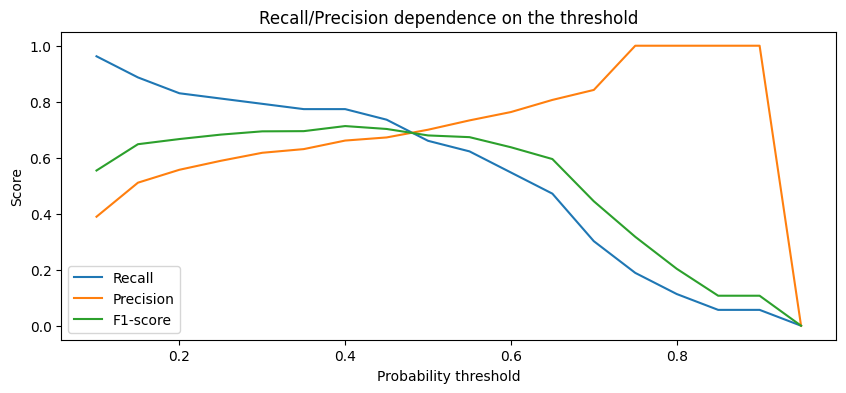

In [76]:
#Нас интересует только вероятность класса (второй столбец)
y_test_proba_pred_logreg = model_logreg.predict_proba(X_test_scaled)[:, 1]
#Для удобства завернем numpy-массив в pandas Series
y_test_proba_pred_logreg = pd.Series(y_test_proba_pred_logreg)
#Создадим списки, в которых будем хранить значения метрик 
recall_scores = []
precision_scores = []
f1_scores = []
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)
#В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    #В противном случае - к классу 0
    y_test_pred = y_test_proba_pred_logreg.apply(lambda x: 1 if x>threshold else 0)
    #Считаем метрики и добавляем их в списки
    recall_scores.append(metrics.recall_score(y_test, y_test_pred))
    precision_scores.append(metrics.precision_score(y_test, y_test_pred))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))

#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')
#Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')

#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')
#Даем графику название и подписи осям
ax.set_title('Recall/Precision dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.legend();

In [77]:

#Задаем оптимальный порог вероятностей
threshold_opt = 0.47
y_test_pred_opt_logreg = y_test_proba_pred_logreg.apply(lambda x: 1 if x > threshold_opt else 0)
#Считаем метрики

print(metrics.classification_report(y_test, y_test_pred_opt_logreg))

              precision    recall  f1-score   support

           0       0.86      0.83      0.85       102
           1       0.70      0.74      0.72        53

    accuracy                           0.80       155
   macro avg       0.78      0.78      0.78       155
weighted avg       0.80      0.80      0.80       155



In [78]:
test_data_scaled

array([[0.        , 1.        , 1.        , ..., 0.        , 1.        ,
        0.        ],
       [0.00239808, 1.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.00479616, 0.5       , 1.        , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.99520384, 1.        , 1.        , ..., 0.        , 0.        ,
        1.        ],
       [0.99760192, 1.        , 1.        , ..., 0.        , 0.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 0.        ,
        0.        ]])

In [79]:
new_test_data

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked_C,Embarked_Q,Embarked_S
891,892,2,1,3,0,0,1,7.8292,0,0,1,0
892,893,2,0,4,1,0,1,7.0000,0,0,0,1
893,894,1,1,0,0,0,1,9.6875,0,0,1,0
894,895,2,1,2,0,0,1,8.6625,0,0,0,1
895,896,2,0,2,1,1,1,12.2875,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,2,1,2,0,0,0,8.0500,0,0,0,1
1305,1306,0,0,3,0,0,0,108.9000,1,1,0,0
1306,1307,2,1,3,0,0,0,7.2500,0,0,0,1
1307,1308,2,1,2,0,0,1,8.0500,0,0,0,1


In [109]:
# рассчитаем точность для тестовой выборки
model_logreg = LogisticRegression(**study_logreg.best_params,random_state=42, )
model_logreg.fit(X_train_scaled, y_train)
pred_logreg = model_logreg.predict(test_data_scaled)


In [111]:
#Нас интересует только вероятность класса (второй столбец)
y_test_proba_pred_logreg = model_logreg.predict_proba(test_data_scaled)[:, 1]
#Для удобства завернем numpy-массив в pandas Series
y_test_proba_pred_logreg = pd.Series(y_test_proba_pred_logreg)


In [113]:
#Задаем оптимальный порог вероятностей
threshold_opt = 0.47
y_test_pred_opt_logreg = y_test_proba_pred_logreg.apply(lambda x: 1 if x > threshold_opt else 0)

In [114]:
y_test_pred_opt_logreg = y_test_pred_opt_logreg.to_numpy()

In [82]:
# # рассчитаем точность для тестовой выборки
# model_rf = ensemble.RandomForestClassifier(**study_rf.best_params,random_state=42, )
# model_rf.fit(X_train_scaled, y_train)
# pred_rf = model_rf.predict(test_data_scaled)


In [99]:
# #Нас интересует только вероятность класса (второй столбец)
# y_test_proba_pred_rf = model_rf.predict_proba(test_data_scaled)[:, 1]
# #Для удобства завернем numpy-массив в pandas Series
# y_test_proba_pred_rf = pd.Series(y_test_proba_pred_rf)

In [100]:
# #Задаем оптимальный порог вероятностей
# threshold_opt = 0.47
# y_test_pred_opt_rf = y_test_proba_pred_rf.apply(lambda x: 1 if x > threshold_opt else 0)


In [104]:
# y_test_pred_opt_rf = y_test_pred_opt_rf.to_numpy()

In [115]:
pass_ID = new_test_data['PassengerId']

In [116]:
pass_ID

891      892
892      893
893      894
894      895
895      896
        ... 
1304    1305
1305    1306
1306    1307
1307    1308
1308    1309
Name: PassengerId, Length: 418, dtype: int64

In [117]:
output = pd.DataFrame({'PassengerId': pass_ID, 'Survived': y_test_pred_opt_logreg})

In [118]:
output

,PassengerId,Survived
891,892,0
892,893,1
893,894,0
894,895,0
895,896,0
...,...,...
1304,1305,0
1305,1306,1
1306,1307,0
1307,1308,0


In [119]:
output.to_csv('logreg_titanic_threshold_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [120]:
output

,PassengerId,Survived
891,892,0
892,893,1
893,894,0
894,895,0
895,896,0
...,...,...
1304,1305,0
1305,1306,1
1306,1307,0
1307,1308,0
